In [72]:
from typing import Annotated, Literal, Sequence, TypedDict

# LangChain core components
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# LangGraph components
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition, ToolNode

# LangChain tools and retriever
from langchain.tools.retriever import create_retriever_tool

# LangChain community integrations
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma

# Text splitting utility
from langchain_text_splitters import RecursiveCharacterTextSplitter


In [73]:
from langchain.embeddings import HuggingFaceEmbeddings

In [74]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [75]:
from langchain_groq import ChatGroq


In [76]:
llm = ChatGroq(model="llama3-70b-8192")

In [77]:
llm.invoke("hi how are you?")

AIMessage(content="Hi! I'm just an AI, I don't have feelings or emotions like humans do. I'm here to help answer any questions you may have, provide assistance, or just chat with you. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 15, 'total_tokens': 63, 'completion_time': 0.153812041, 'prompt_time': 0.000177058, 'queue_time': 0.05972028, 'total_time': 0.153989099}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'stop', 'logprobs': None}, id='run--b2101fda-fe98-44c8-b421-5f3c9007b1ee-0', usage_metadata={'input_tokens': 15, 'output_tokens': 48, 'total_tokens': 63})

In [78]:
urls = [

"https://lilianweng.github.io/posts/2023-06-23-agent/",

"https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",

]

In [79]:
from langchain_community.document_loaders import WebBaseLoader

In [80]:
docs = [WebBaseLoader(url).load() for url in urls]

In [113]:
#docs[0][0].metadata

In [112]:
#docs[1][0].metadata

In [111]:
#docs

In [84]:
docs_list=[
    item for sublist in docs  for item in sublist
]

In [85]:

text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100,
    chunk_overlap=5)

In [110]:
#docs

In [87]:
doc_splits = text_splitter.split_documents(docs_list)

In [88]:
doc_splits

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [89]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    
    collection_name="rag-chroma",
    embedding=embeddings,
)

In [90]:
retriever =vectorstore.as_retriever()

In [91]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)


In [92]:
tools = [retriever_tool]

In [93]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [94]:
class Great(BaseModel):
    binary_score: str = Field(description='Relevance score: "yes" or "no"')


In [95]:
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [96]:
def AI_Assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [97]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]
    model = llm.bind_tools(tools)
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [98]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************


c:\Users\DELL\langgraph_sql\enve\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [99]:
def rewirter(state:AgentState):
    print("---TRANSFORM QUERY---")
    model = llm.bind_tools(tools)
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    response = llm.invoke(msg)
    return {"messages": [response]}


In [100]:
# Add nodes
workflow = StateGraph(AgentState)
workflow.add_node("AI_Assistant", AI_Assistant)
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)
workflow.add_node("rewirter", rewirter)

workflow.add_node("generate", generate)

In [101]:
workflow.add_edge(START, "AI_Assistant")

# Decide to retrieve or end
workflow.add_conditional_edges(
    "AI_Assistant",
    tools_condition,
    {"tools": "retrieve", END: END},
)

In [102]:
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {"rewrite": "rewirter", "generate": "generate"}
)

# Continue the loop or finish
workflow.add_edge("generate", END)
workflow.add_edge("rewirter", "AI_Assistant") 

In [103]:
app=workflow.compile()

In [104]:
app.invoke({
    "messages": [HumanMessage(content="What is an autonomous agent in AI?")]
})

---CALL AGENT---
---CHECK RELEVANCE---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
---DECISION: DOCS RELEVANT---
---GENERATE---


c:\Users\DELL\langgraph_sql\enve\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


{'messages': [HumanMessage(content='What is an autonomous agent in AI?', additional_kwargs={}, response_metadata={}, id='9f6c5607-99da-4920-9104-7790c823a35d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hqvd', 'function': {'arguments': '{"query":"autonomous agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 919, 'total_tokens': 965, 'completion_time': 0.131428571, 'prompt_time': 0.030304201, 'queue_time': 0.054551595999999994, 'total_time': 0.161732772}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ec6c2de2-c974-4559-bddc-137026458667-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'autonomous agent'}, 'id': 'call_hqvd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 919, 'output_tokens': 46, 'total_tokens': 965}),
  ToolMessage(content='LLM Powered Autonomo

In [105]:
graph = workflow.compile()

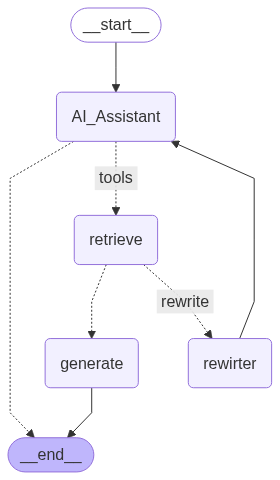

In [106]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [107]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'AI_Assistant':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8qdv', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 1871, 'total_tokens': 1940, 'completion_time': 0.197142857, 'prompt_time': 0.06928719, 'queue_time': -0.1960295, 'total_time': 0.266430047}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_dd4ae1c591', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c4410279-3591-4f67-b2ad-981256c85b43-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_8qdv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1871, 'output_tokens': 69, 'total_tokens': 1940})]}
'\n---\n'
---CHECK RELEVANCE---
"Output from node 'AI_Assistant':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs

c:\Users\DELL\langgraph_sql\enve\lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'According to Lilian Weng, there are two types of agent '
                'memory: Memory Stream and Retrieval Model. Memory Stream is a '
                "long-term memory module that records agents' experience in "
                'natural language.']}
'\n---\n'


In [109]:
app.invoke({
    "messages": [HumanMessage(content="What is an agent in AI?")]
})

---CALL AGENT---


{'messages': [HumanMessage(content='What is an agent in AI?', additional_kwargs={}, response_metadata={}, id='8717539d-6179-419f-a828-f1ca5793c39c'),
  AIMessage(content='In AI, an agent is an autonomous entity that acts on behalf of a user or another entity. It perceives its environment, reasons about the current state of the environment, and acts upon the environment to change its state. Agents can be simple or complex, and they can be implemented using various AI techniques, such as machine learning, rule-based systems, or symbolic reasoning.\n\nAgents can be categorized into different types based on their characteristics, such as:\n\n1. Simple Reflex Agents: These agents react to the current state of the environment without considering future consequences.\n2. Model-Based Reflex Agents: These agents maintain an internal model of the environment and use this model to make decisions.\n3. Goal-Based Agents: These agents have specific goals and make decisions based on the expected outc